In [37]:

import os, sys, json, math, textwrap
import numpy as np
import pandas as pd

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt

# Plot config
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True
pd.options.display.float_format = '{:,.4f}'.format

# Paths
DATA_PATH = os.path.join('data', 'lionstudios_data_analyst_take_home.csv')


In [38]:
# 2) Load data
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head(3)


(73141, 15)


,user_id,platform,variant,install_timestamp,country_type,session_timestamp,icon_shop_opens,inter_shop_opens,icon_cash_purchases,inter_cash_purchases,icon_revenue_usd,inter_revenue_usd,session_length,rvs_watched,levels_played
0,GZeZClCIqP,android,Control,2023-01-07T13:55:32.394Z,Non-US,2023-01-07 13:55:32,0,0,0,0,0.0000,0.0000,53,2,31
1,GZeZClCIqP,android,Control,2023-01-07T13:55:32.394Z,Non-US,2023-01-07 16:02:11,0,0,0,0,0.0000,0.0000,23,3,7
2,GZeZClCIqP,android,Control,2023-01-07T13:55:32.394Z,Non-US,2023-01-08 07:05:13,0,0,0,0,0.0000,0.0000,4,10,11


In [39]:
# 3) Basic info and NA summary
display(df.dtypes)
na = df.isna().sum().sort_values(ascending=False).to_frame('na_count')
na['na_rate'] = na['na_count'] / len(df)
display(na.head(15))


user_id                  object
platform                 object
variant                  object
install_timestamp        object
country_type             object
session_timestamp        object
icon_shop_opens           int64
inter_shop_opens          int64
icon_cash_purchases       int64
inter_cash_purchases      int64
icon_revenue_usd        float64
inter_revenue_usd       float64
session_length            int64
rvs_watched               int64
levels_played             int64
dtype: object

,na_count,na_rate
session_timestamp,5,0.0001
user_id,0,0.0000
platform,0,0.0000
variant,0,0.0000
install_timestamp,0,0.0000
country_type,0,0.0000
icon_shop_opens,0,0.0000
inter_shop_opens,0,0.0000
icon_cash_purchases,0,0.0000
inter_cash_purchases,0,0.0000


In [40]:
# 4) Parse timestamps
for col in ['install_timestamp', 'session_timestamp']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], utc=True, errors='coerce')

# Datatypes after parse
print("\nDtypes after parse:")
print(df[['install_timestamp','session_timestamp']].dtypes)

# NaT counts
print("\nNaT counts after parse:")
print(df[['install_timestamp','session_timestamp']].isna().sum())

# Tarih aralıklarına bakış
for col in ['install_timestamp','session_timestamp']:
    non_null = df[col].dropna()
    print(f"{col}: min={non_null.min()}  max={non_null.max()}  count={len(non_null)}")



Dtypes after parse:
install_timestamp    datetime64[ns, UTC]
session_timestamp    datetime64[ns, UTC]
dtype: object

NaT counts after parse:
install_timestamp    0
session_timestamp    5
dtype: int64
install_timestamp: min=2023-01-01 00:01:18.399000+00:00  max=2023-01-14 23:59:39.411000+00:00  count=73141
session_timestamp: min=2023-01-01 00:01:18+00:00  max=2023-02-01 09:25:41+00:00  count=73136


In [41]:
# 5) Normalize 'variant' robustly (self-contained; does not depend on previous variables)

# 5.1 Find a likely variant column if not strictly named 'variant'
if 'variant' not in df.columns:
    cand_cols = [c for c in df.columns if c.lower() in ('variant','arm','group','bucket','experiment_group','treatment')]
    if len(cand_cols) == 0:
        raise ValueError("No variant/group column detected. Please specify which column identifies control vs test.")
    df.rename(columns={cand_cols[0]: 'variant'}, inplace=True)

# 5.2 Normalize strings
raw = df['variant'].astype(str).str.strip().str.lower()

# 5.3 Map common labels → {'control','test'}
mapping = {
    'control': 'control',
    'control group': 'control',
    'test': 'test',
    'treatment': 'test',
    'treatment group': 'test',
    'variant': 'test',
    '0': 'control',
    '1': 'test',
    'new shop icon': 'test',       # <— your dataset’s label
    'shop icon': 'test'
}

df['variant'] = raw.map(mapping).fillna(raw)

# 5.4 Final safety: if anything still not 'control' or 'test', try keyword-based fallback
mask_unknown = ~df['variant'].isin(['control','test'])
if mask_unknown.any():
    # keyword heuristics
    heur = df.loc[mask_unknown, 'variant']
    df.loc[mask_unknown & heur.str.contains('control', na=False), 'variant'] = 'control'
    df.loc[mask_unknown & heur.str.contains('test|treat|variant|icon', na=False), 'variant'] = 'test'

# 5.5 Assert only two levels remain
vc = df['variant'].value_counts(dropna=False)
print("Variant distribution:\n", vc, "\n")

print("Platform × Variant:")
print(pd.crosstab(df['platform'], df['variant']), "\n")

print("Country × Variant:")
print(pd.crosstab(df['country_type'], df['variant']))


Variant distribution:
 variant
control    41924
test       31217
Name: count, dtype: int64 

Platform × Variant:
variant   control   test
platform                
android     21190  15782
ios         20734  15435 

Country × Variant:
variant       control   test
country_type                
Non-US          32109  21492
US               9815   9725


In [42]:
# 6) Aggregate to user-level metrics
user_df = df.groupby(['user_id','variant'], as_index=False).agg({
    'icon_shop_opens':'sum',
    'inter_shop_opens':'sum',
    'icon_cash_purchases':'sum',
    'inter_cash_purchases':'sum',
    'icon_revenue_usd':'sum',
    'inter_revenue_usd':'sum',
    'session_length':'sum',
    'rvs_watched':'sum',
    'levels_played':'sum'
})

# Derived metrics
user_df['shop_opens'] = user_df['icon_shop_opens'] + user_df['inter_shop_opens']
user_df['cash_purchases'] = user_df['icon_cash_purchases'] + user_df['inter_cash_purchases']
user_df['revenue_usd'] = user_df['icon_revenue_usd'] + user_df['inter_revenue_usd']

# Key binary KPI: did user ever open shop by icon?
user_df['opened_shop_icon'] = (user_df['icon_shop_opens'] > 0).astype(int)

# Summary check
print("User-level rows:", len(user_df))
print(user_df[['variant','shop_opens','cash_purchases','revenue_usd','opened_shop_icon']].head())

# Compare control vs test means
summary = user_df.groupby('variant').agg({
    'opened_shop_icon':'mean',
    'shop_opens':'mean',
    'cash_purchases':'mean',
    'revenue_usd':'mean'
})
print("\nVariant averages:\n", summary)


User-level rows: 20000
   variant  shop_opens  cash_purchases  revenue_usd  opened_shop_icon
0     test           2               0       0.0000                 1
1  control           0               0       0.0000                 0
2  control           0               0       0.0000                 0
3  control           4               3       8.0000                 0
4  control           3               0       0.0000                 0

Variant averages:
          opened_shop_icon  shop_opens  cash_purchases  revenue_usd
variant                                                           
control            0.2039      1.1259          0.6423       1.7683
test               0.1709      0.7581          0.3508       1.0498


In [43]:
from scipy import stats
import numpy as np
import pandas as pd

# Split groups
control = user_df[user_df['variant']=='control']
test = user_df[user_df['variant']=='test']

# --- Test 1: Proportion test for "opened_shop_icon"
control_open = control['opened_shop_icon'].sum()
test_open = test['opened_shop_icon'].sum()
control_n = len(control)
test_n = len(test)

# Proportion
p_control = control_open / control_n
p_test = test_open / test_n

# Z-test for proportions
p_pool = (control_open + test_open) / (control_n + test_n)
se = np.sqrt(p_pool*(1-p_pool)*(1/control_n + 1/test_n))
z = (p_test - p_control) / se
pval_prop = 2 * (1 - stats.norm.cdf(abs(z)))

print("Proportion opened_shop_icon:")
print(f"Control={p_control:.4f}, Test={p_test:.4f}, Δ={p_test-p_control:.4f}, p-value={pval_prop:.4f}")

# --- Test 2: Shop opens (t-test)
t_stat, pval_shop = stats.ttest_ind(control['shop_opens'], test['shop_opens'], equal_var=False)
print("\nShop opens: mean_control=%.4f mean_test=%.4f p=%.4f" % (control['shop_opens'].mean(), test['shop_opens'].mean(), pval_shop))

# --- Test 3: Cash purchases (t-test)
t_stat, pval_purchase = stats.ttest_ind(control['cash_purchases'], test['cash_purchases'], equal_var=False)
print("\nCash purchases: mean_control=%.4f mean_test=%.4f p=%.4f" % (control['cash_purchases'].mean(), test['cash_purchases'].mean(), pval_purchase))

# --- Test 4: Revenue (t-test)
t_stat, pval_revenue = stats.ttest_ind(control['revenue_usd'], test['revenue_usd'], equal_var=False)
print("\nRevenue: mean_control=%.4f mean_test=%.4f p=%.4f" % (control['revenue_usd'].mean(), test['revenue_usd'].mean(), pval_revenue))


Proportion opened_shop_icon:
Control=0.2039, Test=0.1709, Δ=-0.0330, p-value=0.0000

Shop opens: mean_control=1.1259 mean_test=0.7581 p=0.0000

Cash purchases: mean_control=0.6423 mean_test=0.3508 p=0.0000

Revenue: mean_control=1.7683 mean_test=1.0498 p=0.0000


In [49]:
# Rebuild ctrl/test cleanly from user_df and ensure derived columns exist

# 1) Start from user_df safely
udf = user_df.copy()

# 2) (Re)create derived columns in case they were missing
udf['any_purchase']      = (udf['cash_purchases'] > 0).astype(int)
udf['total_revenue']     = udf['revenue_usd']
udf['total_shop_opens']  = udf['shop_opens']
# sessions: if missing on user_df, build from raw df by counting distinct sessions per user
if 'sessions' not in udf.columns:
    ses = df.groupby(['user_id','variant'])['session_timestamp'].nunique().reset_index(name='sessions')
    udf = udf.merge(ses, on=['user_id','variant'], how='left')

# 3) Fresh splits
ctrl = udf[udf['variant'].str.lower().eq('control')].copy()
test = udf[udf['variant'].str.lower().eq('test')].copy()

# 4) Sanity prints
print("Counts:", len(ctrl), len(test))
print("Columns present (ctrl) sample:", sorted(list(set(ctrl.columns) & set(['any_purchase','total_revenue','total_shop_opens','sessions']))))

print("Purchase sum:", int(ctrl['any_purchase'].sum()), int(test['any_purchase'].sum()))
print("Revenue sums:", float(ctrl['total_revenue'].sum()), float(test['total_revenue'].sum()))


Counts: 9396 10604
Columns present (ctrl) sample: ['any_purchase', 'sessions', 'total_revenue', 'total_shop_opens']
Purchase sum: 1256 918
Revenue sums: 16615.0 11132.0


In [50]:
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as st
import numpy as np
import pandas as pd

# --- 0) Safety
required_cols = [
    'variant',
    'shop_opens', 'cash_purchases', 'revenue_usd',
    'icon_shop_opens', 'session_length', 'levels_played', 'rvs_watched'
]
missing = [c for c in required_cols if c not in user_df.columns]
if missing:
    raise ValueError(f"user_df is missing columns: {missing}")

# --- 1) Derived on user_df
user_df = user_df.copy()
user_df['any_purchase']     = (user_df['cash_purchases'] > 0).astype(int)
user_df['total_revenue']    = user_df['revenue_usd']
user_df['total_shop_opens'] = user_df['shop_opens']

# sessions yoksa user-level session sayısını hesapla
if 'sessions' not in user_df.columns:
    ses = df.groupby(['user_id','variant'])['session_timestamp'].nunique().reset_index(name='sessions')
    user_df = user_df.merge(ses, on=['user_id','variant'], how='left')

# --- 2) Split
ctrl = user_df[user_df['variant'].str.lower().eq('control')]
test = user_df[user_df['variant'].str.lower().eq('test')]

print("Counts (users):", len(ctrl), len(test))
if len(ctrl)==0 or len(test)==0:
    raise ValueError("One of the groups is empty. Check variant mapping earlier.")

# --- 3) Proportion test (purchase rate)
pr_ctrl = ctrl['any_purchase'].sum(); n_ctrl = len(ctrl)
pr_test = test['any_purchase'].sum(); n_test = len(test)
z_pr, p_pr = proportions_ztest(count=[pr_test, pr_ctrl], nobs=[n_test, n_ctrl], alternative='two-sided')
print(f"\nPurchase rate: Control={pr_ctrl/n_ctrl:.4%}  Test={pr_test/n_test:.4%}  "
      f"Δ={(pr_test/n_test - pr_ctrl/n_ctrl):.4%}  z={z_pr:.3f}  p={p_pr:.2e}")

# --- 4) Welch t-tests (means)
def welch(a, b): return st.ttest_ind(a, b, equal_var=False, nan_policy='omit')

t_arpu  = welch(test['total_revenue'],    ctrl['total_revenue'])
t_shop  = welch(test['total_shop_opens'], ctrl['total_shop_opens'])
t_icon  = welch(test['icon_shop_opens'],  ctrl['icon_shop_opens'])
t_sess  = welch(test['sessions'],         ctrl['sessions'])
t_play  = welch(test['session_length'],   ctrl['session_length'])
t_lvls  = welch(test['levels_played'],    ctrl['levels_played'])
t_rvs   = welch(test['rvs_watched'],      ctrl['rvs_watched'])

print(f"\nARPU: control={ctrl['total_revenue'].mean():.4f}  test={test['total_revenue'].mean():.4f}  "
      f"t={t_arpu.statistic:.3f}  p={t_arpu.pvalue:.2e}")

print(f"Shop opens: control={ctrl['total_shop_opens'].mean():.4f}  test={test['total_shop_opens'].mean():.4f}  "
      f"t={t_shop.statistic:.3f}  p={t_shop.pvalue:.2e}")

print(f"Icon opens: control={ctrl['icon_shop_opens'].mean():.4f}  test={test['icon_shop_opens'].mean():.4f}  "
      f"t={t_icon.statistic:.3f}  p={t_icon.pvalue:.2e}")

print(f"Sessions: control={ctrl['sessions'].mean():.4f}  test={test['sessions'].mean():.4f}  "
      f"t={t_sess.statistic:.3f}  p={t_sess.pvalue:.2e}")

print(f"Playtime (min): control={ctrl['session_length'].mean():.2f}  test={test['session_length'].mean():.2f}  "
      f"t={t_play.statistic:.3f}  p={t_play.pvalue:.2e}")

print(f"Levels: control={ctrl['levels_played'].mean():.2f}  test={test['levels_played'].mean():.2f}  "
      f"t={t_lvls.statistic:.3f}  p={t_lvls.pvalue:.2e}")

print(f"RVs: control={ctrl['rvs_watched'].mean():.2f}  test={test['rvs_watched'].mean():.2f}  "
      f"t={t_rvs.statistic:.3f}  p={t_rvs.pvalue:.2e}")


Counts (users): 9396 10604

Purchase rate: Control=13.3674%  Test=8.6571%  Δ=-4.7103%  z=-10.681  p=1.25e-26

ARPU: control=1.7683  test=1.0498  t=-10.600  p=3.60e-26
Shop opens: control=1.1259  test=0.7581  t=-16.746  p=1.75e-62
Icon opens: control=0.4337  test=0.4097  t=-1.683  p=9.24e-02
Sessions: control=4.4617  test=2.9436  t=-55.574  p=0.00e+00
Playtime (min): control=123.97  test=94.96  t=-29.342  p=8.90e-185
Levels: control=64.14  test=49.96  t=-25.788  p=5.24e-144
RVs: control=60.27  test=34.53  t=-59.052  p=0.00e+00


In [51]:
summary = user_df.groupby('variant').agg(
    n_users = ('user_id','nunique'),
    arpu    = ('total_revenue','mean'),
    purchase_rate = ('any_purchase','mean'),
    avg_shop_opens = ('total_shop_opens','mean'),
    avg_icon_opens = ('icon_shop_opens','mean'),
    sessions = ('sessions','mean'),
    play_time_min = ('session_length','mean'),
    levels = ('levels_played','mean'),
    rvs = ('rvs_watched','mean')
).reset_index()

summary


,variant,n_users,arpu,purchase_rate,avg_shop_opens,avg_icon_opens,sessions,play_time_min,levels,rvs
0,control,9396,1.7683,0.1337,1.1259,0.4337,4.4617,123.9696,64.1406,60.2652
1,test,10604,1.0498,0.0866,0.7581,0.4097,2.9436,94.9629,49.9554,34.5340


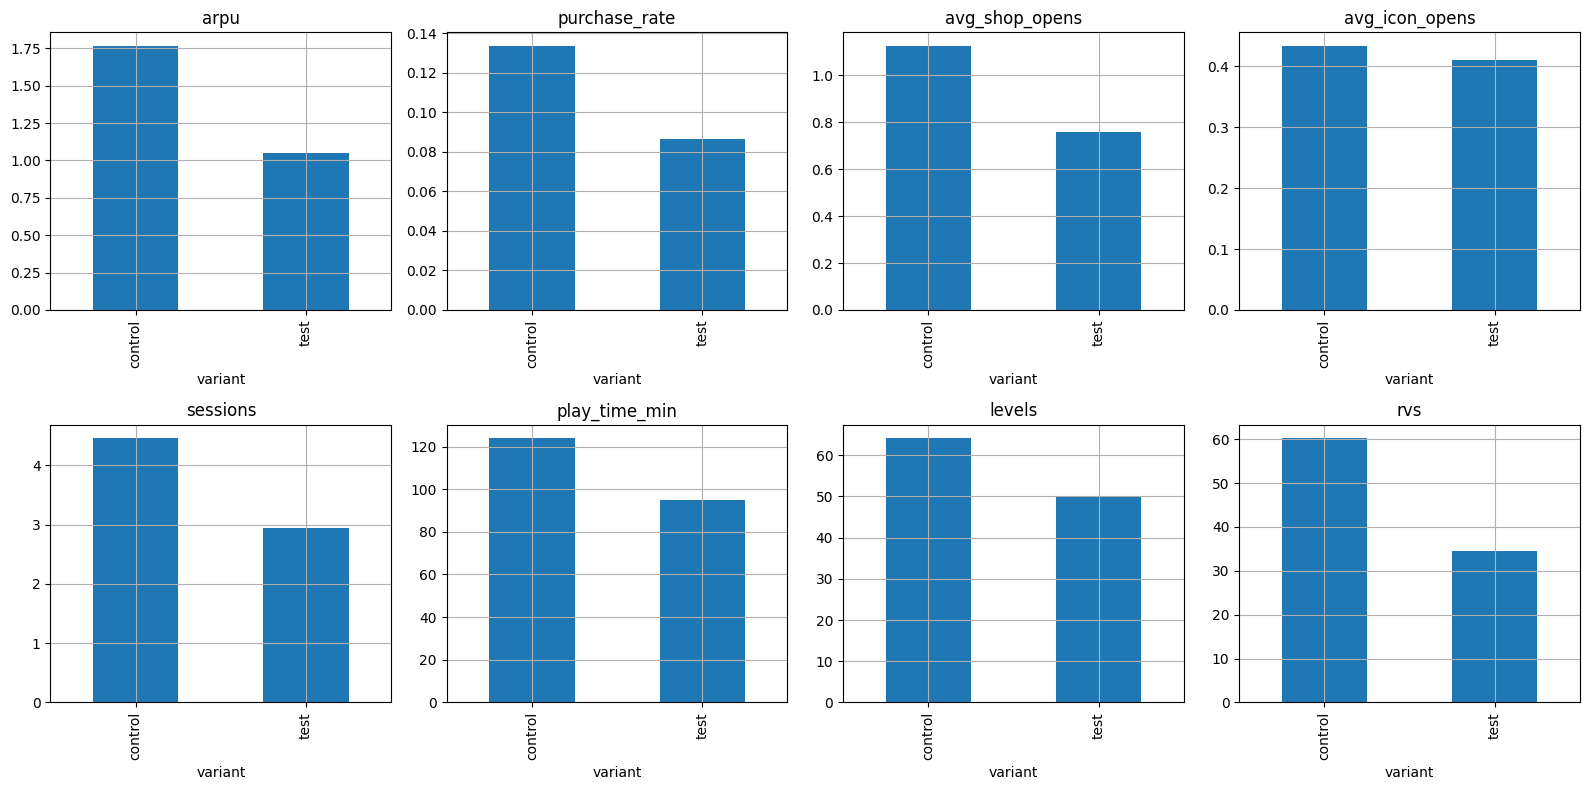

In [47]:
metrics = [
    'arpu', 'purchase_rate', 'avg_shop_opens', 'avg_icon_opens',
    'sessions', 'play_time_min', 'levels', 'rvs'
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax, m in zip(axes, metrics):
    summary.plot(kind='bar', x='variant', y=m, ax=ax, legend=False, title=m)

plt.tight_layout()
plt.show()


In [52]:
# ==== SEGMENTED USER-LEVEL AGG + TESTS (platform & country_type) ====

import numpy as np
import pandas as pd
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

# ---------- A) Re-aggregate to user-level while KEEPING platform & country ----------
# We aggregate from the original session-level df.
# For sessions count, use nunique(session_timestamp) at user×variant×platform×country granularity.

agg = (df
       .groupby(['user_id', 'variant', 'platform', 'country_type'], as_index=False)
       .agg(
           icon_shop_opens    = ('icon_shop_opens', 'sum'),
           inter_shop_opens   = ('inter_shop_opens', 'sum'),
           icon_cash_purchases= ('icon_cash_purchases', 'sum'),
           inter_cash_purchases=('inter_cash_purchases', 'sum'),
           icon_revenue_usd   = ('icon_revenue_usd', 'sum'),
           inter_revenue_usd  = ('inter_revenue_usd', 'sum'),
           session_length     = ('session_length', 'sum'),
           rvs_watched        = ('rvs_watched', 'sum'),
           levels_played      = ('levels_played', 'sum'),
           sessions           = ('session_timestamp', 'nunique')  # user-level session count
       ))

# Derived totals (user-level)
agg['shop_opens']     = agg['icon_shop_opens'].fillna(0) + agg['inter_shop_opens'].fillna(0)
agg['cash_purchases'] = agg['icon_cash_purchases'].fillna(0) + agg['inter_cash_purchases'].fillna(0)
agg['revenue_usd']    = agg['icon_revenue_usd'].fillna(0.0) + agg['inter_revenue_usd'].fillna(0.0)

# Binary conversions (user-level)
agg['any_purchase']      = (agg['cash_purchases'] > 0).astype(int)
agg['opened_shop_icon']  = (agg['icon_shop_opens'] > 0).astype(int)

# Convenience aliases for tests/summary
agg['total_revenue']     = agg['revenue_usd']
agg['total_shop_opens']  = agg['shop_opens']
agg['play_time_min']     = agg['session_length']
agg['levels']            = agg['levels_played']
agg['rvs']               = agg['rvs_watched']

print("User-level rows with segments:", len(agg))
print(agg[['variant','platform','country_type']].head())

# ---------- B) Test helpers ----------
def two_prop_z(c_success, c_total, t_success, t_total):
    """Two-proportion z-test (two-sided). Returns (z, p)."""
    return proportions_ztest(count=[t_success, c_success],
                             nobs=[t_total, c_total],
                             alternative='two-sided')

def welch_t(a, b):
    """Welch’s t-test (independent samples, unequal variance). Returns object with .statistic, .pvalue."""
    return st.ttest_ind(a, b, equal_var=False, nan_policy='omit')

# ---------- C) Driver to run segmented analysis ----------
def run_segment_tests(df_user, segment_col, label):
    print(f"\n===== Segment analysis: {label} =====")
    for seg_val, seg_df in df_user.groupby(segment_col):
        print(f"\n--- {label} = {seg_val} ---")
        ctrl = seg_df[seg_df['variant'].str.lower().eq('control')]
        test = seg_df[seg_df['variant'].str.lower().eq('test')]

        n_ctrl, n_test = len(ctrl), len(test)
        print(f"Counts (users) → control={n_ctrl}, test={n_test}")
        if n_ctrl < 100 or n_test < 100:
            print("Too few users in this segment; skipping significance tests.")
            continue

        # Purchase rate (proportion test)
        pr_ctrl = ctrl['any_purchase'].mean()
        pr_test = test['any_purchase'].mean()
        z_pr, p_pr = two_prop_z(ctrl['any_purchase'].sum(), n_ctrl,
                                test['any_purchase'].sum(), n_test)
        print(f"Purchase rate: ctrl={pr_ctrl:.4%}, test={pr_test:.4%}, Δ={(pr_test-pr_ctrl):.2%}, z={z_pr:.3f}, p={p_pr:.2e}")

        # ARPU
        t_arpu = welch_t(test['total_revenue'], ctrl['total_revenue'])
        print(f"ARPU:         ctrl={ctrl['total_revenue'].mean():.4f}, test={test['total_revenue'].mean():.4f}, "
              f"t={t_arpu.statistic:.3f}, p={t_arpu.pvalue:.2e}")

        # Shop opens
        t_shop = welch_t(test['total_shop_opens'], ctrl['total_shop_opens'])
        print(f"Shop opens:   ctrl={ctrl['total_shop_opens'].mean():.4f}, test={test['total_shop_opens'].mean():.4f}, "
              f"t={t_shop.statistic:.3f}, p={t_shop.pvalue:.2e}")

        # Playtime
        t_play = welch_t(test['play_time_min'], ctrl['play_time_min'])
        print(f"Playtime(min):ctrl={ctrl['play_time_min'].mean():.2f}, test={test['play_time_min'].mean():.2f}, "
              f"t={t_play.statistic:.3f}, p={t_play.pvalue:.2e}")

# ---------- D) Run segments ----------
run_segment_tests(agg, 'platform', 'Platform')
run_segment_tests(agg, 'country_type', 'Country')


User-level rows with segments: 20000
   variant platform country_type
0     test      ios       Non-US
1  control      ios       Non-US
2  control  android       Non-US
3  control      ios       Non-US
4  control  android       Non-US

===== Segment analysis: Platform =====

--- Platform = android ---
Counts (users) → control=5053, test=5669
Purchase rate: ctrl=4.2153%, test=3.0517%, Δ=-1.16%, z=-3.229, p=1.24e-03
ARPU:         ctrl=0.4386, test=0.3022, t=-3.230, p=1.24e-03
Shop opens:   ctrl=1.0325, test=0.7084, t=-11.287, p=2.28e-29
Playtime(min):ctrl=97.88, test=75.51, t=-23.107, p=5.71e-115

--- Platform = ios ---
Counts (users) → control=4343, test=4935
Purchase rate: ctrl=24.0157%, test=15.0963%, Δ=-8.92%, z=-10.869, p=1.63e-27
ARPU:         ctrl=3.3155, test=1.9086, t=-10.569, p=6.22e-26
Shop opens:   ctrl=1.2346, test=0.8152, t=-12.448, p=2.89e-35
Playtime(min):ctrl=154.33, test=117.31, t=-22.477, p=1.44e-108

===== Segment analysis: Country =====

--- Country = Non-US ---
Coun